Install neccessary packages 

In [1]:
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [1]:
from urllib import request as rq
import pandas as pd
import os
import pyarrow as pa # not sure will i use this 
import numpy as np
import ipywidgets
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, VBox
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

Download the Dublin Bus data from https://data.gov.ie/organization/dublin-city-council?tags=Transport+and+Infrastructure

Use a generator to load the data into pandas data frame https://pandasninja.com/2019/04/how-to-read-lots-of-csv-files-easily-into-pandas/#:~:text=How%20to%20read%20lots%20of%20csv%20files%20easily,need%20...%204%204.%20Leverage%20regular%20expressions%20


In [2]:
# Function to load the Dublin bus gz files 
def load_Files(files):
    columns = ['Timestamp', 'LineID', 'Direction', 'JourneyPatternID', 'TimeFrame', 'VehicleJourneyID', 'Operator', 'Congestion', 'LonWGS84', 'LatWGS84', 'Delay', 'BlockID', 'VehicleID', 'StopID', 'AtStop']
    for f in files:
        print(f)
        yield pd.read_csv('./Data/Bus/Gz/' + f, compression='gzip', delimiter=',', header=0, names=columns, parse_dates=True, low_memory=True)

# Check parquet file existence before downloading - iof starting from afresh this takes a long time
if os.path.exists('./Data/Bus/CleanedBusData.parquet'):
    print("Parquest file exists, means the Bus data has been downloaded already ")
    df = pd.read_parquet('./Data/Bus/CleanedBusData.parquet')
else:
    os.makedirs('./Zips/Bus/', exist_ok = True)
    url = "https://opendata.dublincity.ie/TrafficOpenData/sir010113-310113.zip"
    busFile = rq.urlretrieve(url, './Zips/Bus/DublinBusdata.zip' )  
    import zipfile as zip
    # Zip creates its own folders - no need to check for folder existence
    with zip.ZipFile(busFile[0],  mode='r') as arc: 
        arc.extractall('./Data/Bus/Gz/')  
    files = os.listdir('./Data/Bus/Gz/')
    DBfiles = [f for f in files if f.endswith('.gz')]
    df = pd.concat(load_Files(DBfiles), copy = False)



Parquest file exists, means the Bus data has been downloaded already 


In [3]:
ColumnsToExclude = ('JourneyPatternID', 'StopID')

# Data is loaded - now needs to be cleaned, there is an argument to be made to include this in the above cell 
# but I have added it here so that I can add more columns to be excluded as I go rather than load the raw data each time
for c in ColumnsToExclude:
    if c in df.columns:
        df = df.drop(c, axis=1)
    else:
        print('Columns already dropped')



Columns already dropped
Columns already dropped


In [4]:
df.head()

,Timestamp,LineID,Direction,TimeFrame,VehicleJourneyID,Operator,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,AtStop,datetime,Time
0,1356998405000000,27.0,0,2012-12-31,3883,RD,0,-6.233417,53.342232,0,27017,33521,0,2013-01-01 00:00:05,00:00:05
1,1356998407000000,40.0,0,2012-12-31,2226,HN,0,-6.278250,53.416683,0,40206,33142,0,2013-01-01 00:00:07,00:00:07
2,1356998407000000,7.0,0,2012-12-31,6106,D1,0,-6.231633,53.317768,0,7019,43004,1,2013-01-01 00:00:07,00:00:07
3,1356998411000000,747.0,0,2012-12-31,3531,SL,0,-6.254617,53.355484,-454,747007,40039,0,2013-01-01 00:00:11,00:00:11
4,1356998411000000,56.0,0,2012-12-31,1830,RD,0,-6.233183,53.342201,0,56001,33488,0,2013-01-01 00:00:11,00:00:11


In [5]:
# Deal with the timestamp and make it human readable
df['datetime'] = pd.to_datetime(df['Timestamp'], unit='us')
df['Time'] = df['datetime'].dt.time

In [6]:
print(df.head())
print(df.Time)

<bound method NDFrame.head of                Timestamp  LineID  Direction   TimeFrame  VehicleJourneyID  \
0       1356998405000000    27.0          0  2012-12-31              3883   
1       1356998407000000    40.0          0  2012-12-31              2226   
2       1356998407000000     7.0          0  2012-12-31              6106   
3       1356998411000000   747.0          0  2012-12-31              3531   
4       1356998411000000    56.0          0  2012-12-31              1830   
...                  ...     ...        ...         ...               ...   
603915  1359632694000000    39.0          0  2013-01-31              3247   
603916  1359632694000000     9.0          0  2013-01-31              3649   
603917  1359632694000000    41.0          0  2013-01-31               112   
603918  1359632694000000   145.0          0  2013-01-31              6810   
603919  1359632694000000   145.0          0  2013-01-31              6471   

       Operator  Congestion  LonWGS84   LatWG

In [7]:
print ('The data has {} Rows and {} columns'.format(df.shape[0],df.shape[1]))
print("The types of columns are:")
df.dtypes

The data has 44455102 Rows and 15 columns
The types of columns are:


Timestamp                    int64
LineID                     float64
Direction                    int64
TimeFrame                   object
VehicleJourneyID             int64
Operator                    object
Congestion                   int64
LonWGS84                   float64
LatWGS84                   float64
Delay                        int64
BlockID                      int64
VehicleID                    int64
AtStop                       int64
datetime            datetime64[ns]
Time                        object
dtype: object

In [8]:
# Getting the list of column Types
CategoricalColumns = list(set(['LineID', 'Direction', 'TimeFrame', 'VehicleJourneyID', 'Operator', 'Congestion',  'Delay', 'BlockID', 'VehicleID', 'StopID', 'AtStop']))
NumericalColumns = list(set(list(df.select_dtypes([np.number]).columns)))
#objectTypeColumns = list(set(list(df.select_dtypes([np.object_]).columns)))
DateColumns = list(set(list(df.select_dtypes([np.datetime64]).columns)))


#print(objectTypeColumns)


CategoricalColumns = list(set(CategoricalColumns) - set(ColumnsToExclude)-set(DateColumns))
NumericalColumns = list(set(NumericalColumns)-set(ColumnsToExclude)-set(DateColumns))

print(CategoricalColumns)
print(NumericalColumns)
print(DateColumns)


['Delay', 'TimeFrame', 'BlockID', 'Direction', 'AtStop', 'Congestion', 'Operator', 'VehicleID', 'VehicleJourneyID', 'LineID']
['LonWGS84', 'Delay', 'LatWGS84', 'BlockID', 'Direction', 'AtStop', 'Congestion', 'VehicleID', 'VehicleJourneyID', 'Timestamp', 'LineID']
['datetime']


In [9]:
def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x))

temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']
unq_df = pd.DataFrame(df.apply(num_unique, axis=0))
unq_df.columns = ['unique']
types_df = pd.DataFrame(df.dtypes)
types_df.columns = ['DataType']

In [10]:
df.describe()


,Timestamp,LineID,Direction,VehicleJourneyID,Congestion,LonWGS84,LatWGS84,Delay,BlockID,VehicleID,AtStop
count,4.445510e+07,4.445304e+07,44455102.0,4.445510e+07,4.445510e+07,4.445510e+07,4.445510e+07,4.445510e+07,4.445510e+07,4.445510e+07,4.445510e+07
mean,1.358318e+15,7.796879e+01,0.0,9.417122e+03,1.163261e-02,-6.272803e+00,5.334513e+01,-2.816513e+01,1.092438e+05,3.542925e+04,2.335773e-01
std,7.394928e+11,1.146419e+02,0.0,6.159844e+04,1.072254e-01,8.389025e-02,5.488354e-02,4.729678e+02,1.921244e+05,3.281093e+03,4.231063e-01
min,1.356998e+15,1.000000e+00,0.0,1.000000e+00,0.000000e+00,-6.617517e+00,5.306802e+01,-1.504500e+04,3.900000e+02,2.804700e+04,0.000000e+00
25%,1.357679e+15,2.500000e+01,0.0,2.536000e+03,0.000000e+00,-6.308650e+00,5.332005e+01,-2.090000e+02,1.602000e+04,3.330800e+04,0.000000e+00
50%,1.358327e+15,4.000000e+01,0.0,4.718000e+03,0.000000e+00,-6.261600e+00,5.334645e+01,0.000000e+00,4.020500e+04,3.352500e+04,0.000000e+00
75%,1.358955e+15,8.300000e+01,0.0,6.769000e+03,0.000000e+00,-6.233166e+00,5.337533e+01,1.040000e+02,8.400400e+04,3.802500e+04,0.000000e+00
max,1.359633e+15,7.470000e+02,0.0,9.998560e+05,1.000000e+00,-6.052917e+00,5.360873e+01,1.161220e+05,8.350020e+05,4.307800e+04,1.000000e+00


In [11]:
summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)
summary_df

,count,mean,std,min,25%,50%,75%,max,missing,unique,DataType
Timestamp,44455102.0,1.358318e+15,7.394928e+11,1.356998e+15,1.357679e+15,1.358327e+15,1.358955e+15,1.359633e+15,0,813103,int64
LineID,44453044.0,7.796879e+01,1.146419e+02,1.000000e+00,2.500000e+01,4.000000e+01,8.300000e+01,7.470000e+02,2058,67,float64
Direction,44455102.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,1,int64
VehicleJourneyID,44455102.0,9.417122e+03,6.159844e+04,1.000000e+00,2.536000e+03,4.718000e+03,6.769000e+03,9.998560e+05,0,18614,int64
Congestion,44455102.0,1.163261e-02,1.072254e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0,2,int64
LonWGS84,44455102.0,-6.272803e+00,8.389025e-02,-6.617517e+00,-6.308650e+00,-6.261600e+00,-6.233166e+00,-6.052917e+00,0,456755,float64
LatWGS84,44455102.0,5.334513e+01,5.488354e-02,5.306802e+01,5.332005e+01,5.334645e+01,5.337533e+01,5.360873e+01,0,131327,float64
Delay,44455102.0,-2.816513e+01,4.729678e+02,-1.504500e+04,-2.090000e+02,0.000000e+00,1.040000e+02,1.161220e+05,0,12638,int64
BlockID,44455102.0,1.092438e+05,1.921244e+05,3.900000e+02,1.602000e+04,4.020500e+04,8.400400e+04,8.350020e+05,0,1238,int64
VehicleID,44455102.0,3.542925e+04,3.281093e+03,2.804700e+04,3.330800e+04,3.352500e+04,3.802500e+04,4.307800e+04,0,911,int64


In [12]:
col_names = list(types_df.index)
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index:
    if col_names[i] in CategoricalColumns:
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
summary_df_cat

,missing,unique,DataType
LineID,2058,67,float64
Direction,0,1,int64
TimeFrame,0,32,object
VehicleJourneyID,0,18614,int64
Operator,0,8,object
Congestion,0,2,int64
Delay,0,12638,int64
BlockID,0,1238,int64
VehicleID,0,911,int64
AtStop,0,2,int64


In [13]:
df.to_parquet('./Data/Bus/CleanedBusData.parquet')

Download the weather station details https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv

In [15]:
url = 'https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv'


Load the weather statio details for Dublin

In [16]:
weatherStations = pd.read_csv(url)
weatherStations = weatherStations[weatherStations['county'].str.contains('Dublin')]
weatherStations.head(10)

,county,station name,name,height(m),easting,northing,latitude,longitude,open year,close year
575,Dublin,10323,STILLORGAN (FARMLEIGH),67,320514,227230,53.28194,-6.19389,1915,1935
576,Dublin,10123,DUBLIN (FITZWILLIAM SQUARE),16,316404,233098,53.33556,-6.25333,1908,1937
577,Dublin,10223,ROYAL BOTANIC GARDENS (GLASNEVIN,17,315083,237179,53.37250,-6.27167,1880,1925
578,Dublin,1223,BELGARD CASTLE,125,307400,229300,53.30278,-6.38889,1914,1963
579,Dublin,632,LUSK G.S.,23,321700,254300,53.52500,-6.16528,1949,2012
580,Dublin,1232,KINSALEY (AGR.RES.STN.),19,321500,242900,53.42222,-6.17222,1961,2004
581,Dublin,2523,DUBLIN (Ringsend),7,318900,233900,53.34167,-6.21389,1911,(null)
582,Dublin,2623,HOWTH CASTLE,11,327900,239000,53.38611,-6.07778,1913,1971
583,Dublin,2723,STILLORGAN (VARTRY HSE.),80,320200,226800,53.27778,-6.19722,1915,1999
584,Dublin,2732,ARDGILLAN,62,321791,261102,53.58583,-6.16167,1894,1938


In [19]:
sns.pairplot(df)

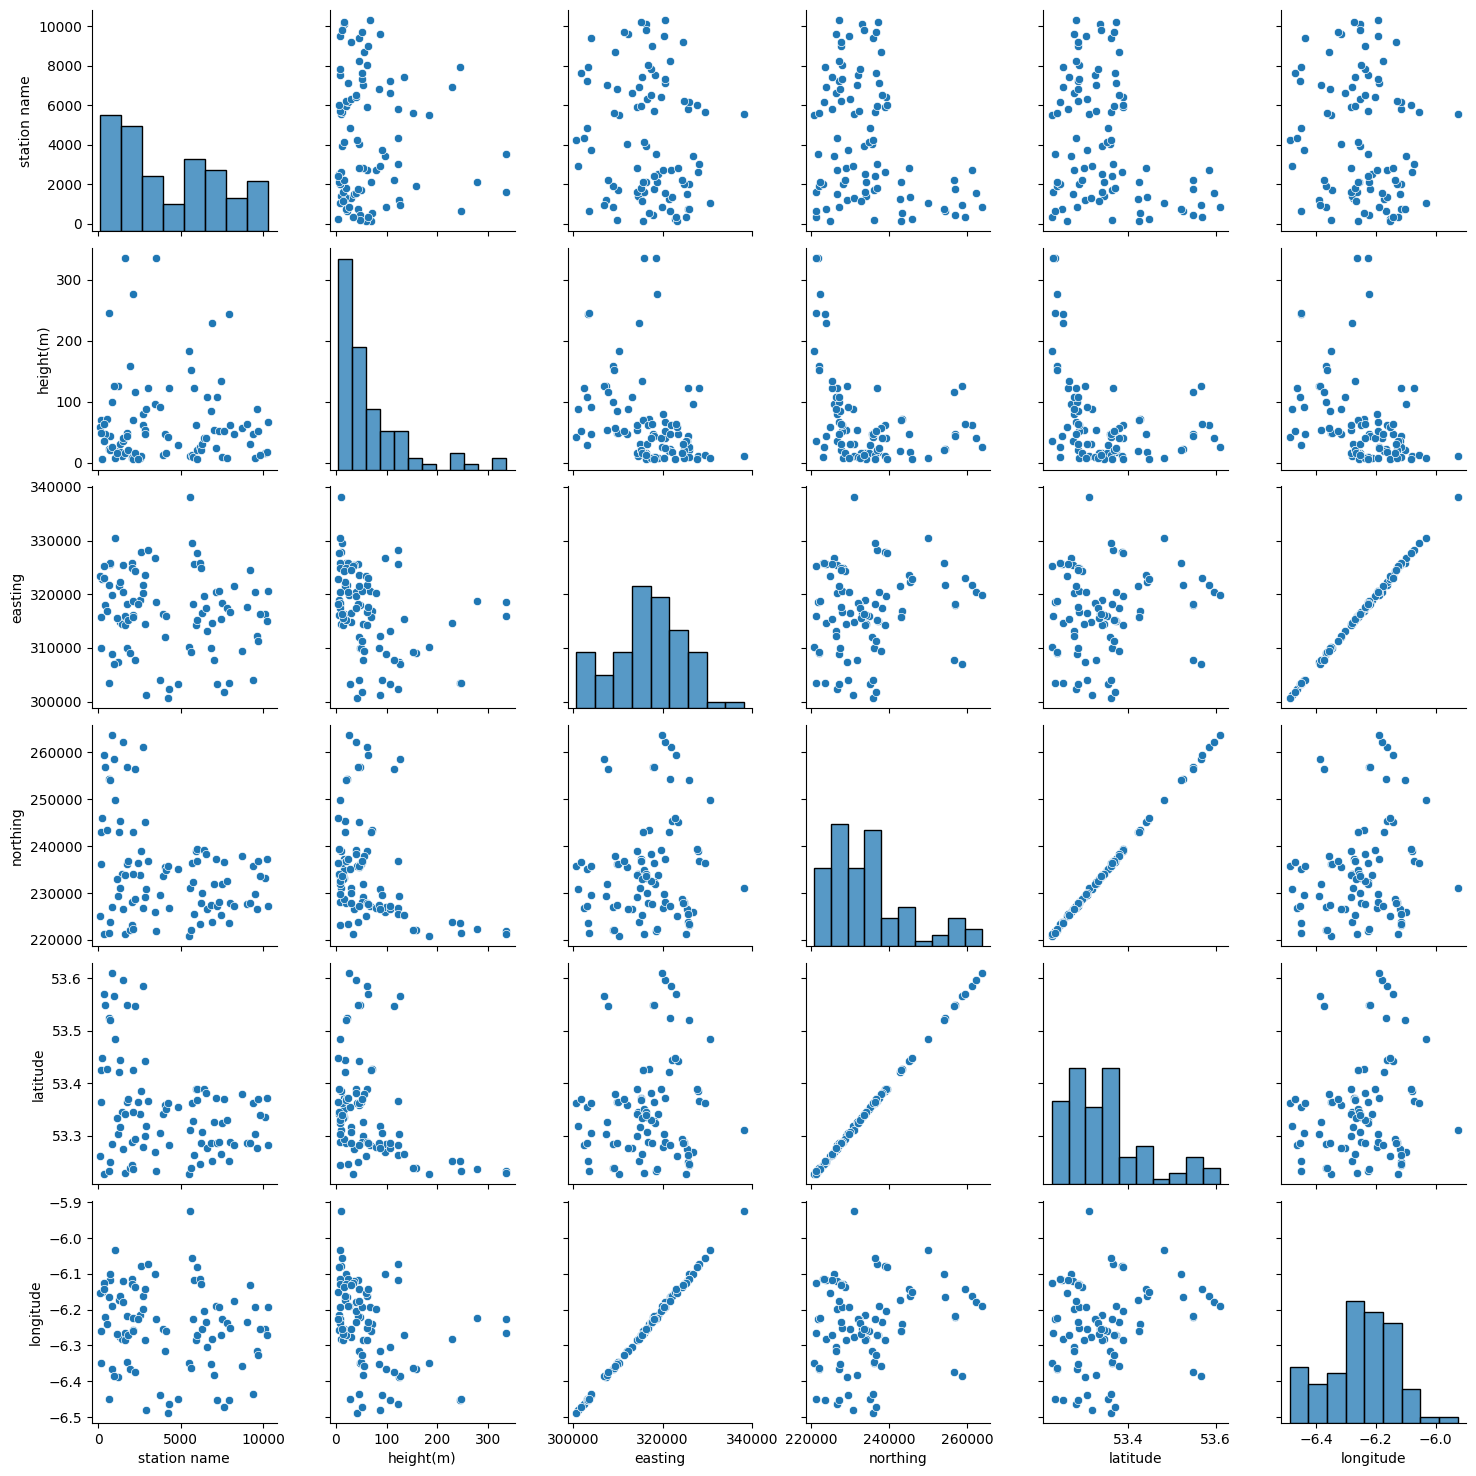

In [18]:
sns.pairplot(weatherStations)